In [48]:
# IGNORE THIS. Solve some issues with imports on my laptop

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import ast
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

/home/leo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/leo/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data loading

In [3]:
df = pd.read_csv('data/movie_features_v5.csv')

In [4]:
display(df.head())

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages,...,average_actor_exp,min_actor_exp,max_actor_exp,multiplier,year,year_group,category,title_word_count,release_quarter,spoken_languages_count
0,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"['Horror', 'Mystery']",['United States of America'],['English'],...,5.600000,0.0,14.0,13.595000,2023,2020,low,4,4,1
1,951491.0,Saw X,13000000.0,100900000.0,2023-09-26,118.0,en,"['Horror', 'Thriller']",['United States of America'],"['Norsk', 'Español', 'English']",...,5.857143,0.0,11.0,7.761538,2023,2020,low,2,3,3
2,762430.0,Retribution,20000000.0,16700000.0,2023-08-23,91.0,en,"['Action', 'Thriller', 'Crime']","['France', 'Germany', 'United States of America']","['Deutsch', 'English']",...,9.142857,0.0,41.0,0.835000,2023,2020,low,1,3,2
3,678512.0,Sound of Freedom,14500000.0,247800000.0,2023-07-03,131.0,en,"['Action', 'Drama']",['United States of America'],"['English', 'Español']",...,7.285714,1.0,13.0,17.089655,2023,2020,low,3,3,2
4,820525.0,After Everything,14000000.0,9700000.0,2023-09-13,93.0,en,"['Romance', 'Drama']",['United States of America'],"['English', 'Português']",...,3.200000,0.0,8.0,0.692857,2023,2020,low,2,3,2


In [5]:
original_language_onehot = pd.get_dummies(df['original_language'], prefix='onehot', prefix_sep='_')

# for col in original_language_onehot.columns:
#     if original_language_onehot[col].sum() < 30:
#         print(col)
#         original_language_onehot.drop(col, axis=1, inplace=True)
# display(original_language_onehot.head())

# Concatenate the new one-hot encoded columns to the original dataframe
df = pd.concat([df, original_language_onehot], axis=1)

In [6]:
def get_column_per_value(df, column_name):
    df[column_name] = df[column_name].apply(ast.literal_eval)

    # Extract unique genres
    unique_genres = set(genre for genres_list in df[column_name] for genre in genres_list)

    # Create one-hot encoded columns for each genre
    for genre in unique_genres:
        df[f'onehot_{column_name}_' + genre.lower()] = df[column_name].apply(lambda x: 1 if genre in x else 0)

In [7]:
get_column_per_value(df, 'genres')
get_column_per_value(df, 'production_countries')
get_column_per_value(df, 'spoken_languages')

/tmp/ipykernel_9542/2900943582.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'onehot_{column_name}_' + genre.lower()] = df[column_name].apply(lambda x: 1 if genre in x else 0)
/tmp/ipykernel_9542/2900943582.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'onehot_{column_name}_' + genre.lower()] = df[column_name].apply(lambda x: 1 if genre in x else 0)
/tmp/ipykernel_9542/2900943582.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

In [8]:
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

In [9]:
input_df = df.drop(['multiplier','budget', 'revenue', 'movie_id', 'release_date', 'title', 'year', 'year_group', 'genres', 'original_language', 'production_countries', 'spoken_languages'], axis=1)
display(input_df.head())
output_df = df['multiplier']


,runtime,number_characters,below18,above60,male_ratio,average_age,max_age,min_age,average_popularity,max_popularity,...,onehot_spoken_languages_català,onehot_spoken_languages_română,onehot_spoken_languages_deutsch,onehot_spoken_languages_한국어/조선말,onehot_spoken_languages_?????,onehot_spoken_languages_ਪੰਜਾਬੀ,onehot_spoken_languages_bosanski,onehot_spoken_languages_pусский,onehot_spoken_languages_हिन्दी,onehot_spoken_languages_български език
0,110.0,5.0,0.200000,0.000000,0.600000,36.800000,57.0,12.0,56.929800,147.890,...,0,0,0,0,0,0,0,0,0,0
1,118.0,7.0,0.000000,0.142857,0.571429,54.000000,81.0,24.0,22.167857,32.931,...,0,0,0,0,0,0,0,0,0,0
2,91.0,7.0,0.142857,0.285714,0.428571,43.285714,71.0,16.0,39.837857,155.962,...,0,0,1,0,0,0,0,0,0,0
3,131.0,7.0,0.000000,0.142857,0.857143,53.000000,70.0,30.0,17.398429,27.814,...,0,0,0,0,0,0,0,0,0,0
4,93.0,10.0,0.000000,0.000000,0.500000,37.100000,60.0,25.0,23.053900,37.079,...,0,0,0,0,0,0,0,0,0,0


In [10]:
input_l = input_df[input_df['category'] == 'low'].drop(['category'], axis=1)
input_h = input_df[input_df['category'] == 'high'].drop(['category'], axis=1)
output_l = output_df[input_df['category'] == 'low']
output_h = output_df[input_df['category'] == 'high']

In [11]:
def remove_outliers(input, output, low=0.2, high=0.8):
    threshold_low = output.quantile(0.2)
    threshold_high = output.quantile(0.8)
    input = input[output < threshold_high]
    input = input[output > threshold_low]
    output = output[output < threshold_high]
    output = output[output > threshold_low]
    return input, output

In [12]:
input_low, output_low = remove_outliers(input_l, output_l, low=0.1, high=0)
input_high, output_high = remove_outliers(input_h, output_h, low=0, high=0.9)

/tmp/ipykernel_9542/1211680359.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input = input[output > threshold_low]


In [13]:
for col in input_high.columns:
    if (input_high[col].sum() < 25) and ('onehot' in col):
        print(col)
        input_high.drop(col, axis=1, inplace=True)

onehot_cn
onehot_cs
onehot_da
onehot_de
onehot_es
onehot_fi
onehot_fr
onehot_hi
onehot_id
onehot_it
onehot_ja
onehot_kn
onehot_ko
onehot_la
onehot_nl
onehot_no
onehot_pt
onehot_ru
onehot_sv
onehot_te
onehot_th
onehot_tr
onehot_zh
onehot_genres_tv movie
onehot_genres_documentary
onehot_genres_music
onehot_genres_western
onehot_production_countries_romania
onehot_production_countries_japan
onehot_production_countries_italy
onehot_production_countries_ghana
onehot_production_countries_poland
onehot_production_countries_peru
onehot_production_countries_ukraine
onehot_production_countries_thailand
onehot_production_countries_czech republic
onehot_production_countries_indonesia
onehot_production_countries_slovenia
onehot_production_countries_argentina
onehot_production_countries_slovakia
onehot_production_countries_sweden
onehot_production_countries_finland
onehot_production_countries_ireland
onehot_production_countries_greece
onehot_production_countries_hungary
onehot_production_countries_s

In [14]:
for col in input_low.columns:
    if (input_low[col].sum() < 20) and ('onehot' in col):
        print(col)
        input_low.drop(col, axis=1, inplace=True)

onehot_cn
onehot_cs
onehot_da
onehot_de
onehot_es
onehot_fi
onehot_fr
onehot_id
onehot_it
onehot_ja
onehot_kn
onehot_la
onehot_nl
onehot_no
onehot_pt
onehot_ru
onehot_sv
onehot_te
onehot_th
onehot_tr
onehot_zh
onehot_genres_tv movie
onehot_genres_documentary
onehot_genres_war
onehot_genres_western
onehot_production_countries_romania
onehot_production_countries_italy
onehot_production_countries_ghana
onehot_production_countries_poland
onehot_production_countries_peru
onehot_production_countries_ukraine
onehot_production_countries_thailand
onehot_production_countries_czech republic
onehot_production_countries_indonesia
onehot_production_countries_slovenia
onehot_production_countries_argentina
onehot_production_countries_slovakia
onehot_production_countries_sweden
onehot_production_countries_finland
onehot_production_countries_ireland
onehot_production_countries_greece
onehot_production_countries_hungary
onehot_production_countries_brazil
onehot_production_countries_liechtenstein
onehot_p

In [15]:
#standardize input low budgets
def standardize_input(input):
    scaler = StandardScaler()
    scaler.fit(input)
    standardized_input = pd.DataFrame(scaler.transform(input))
    standardized_input.columns = input.columns
    standardized_input.index = input.index
    return standardized_input

standardized_input_low = standardize_input(input_low)
standardized_input_high = standardize_input(input_high)


## Models testing

In [40]:
X_train, X_test, y_train, y_test = train_test_split(input_high, output_high, test_size=0.15, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
print(r2_score(y_test, y_pred))
results.summary()

0.20624844846399748


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             multiplier   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.886
Method:                 Least Squares   F-statistic:                              108.7
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                   6.60e-268
Time:                        16:48:14   Log-Likelihood:                         -810.79
No. Observations:                 666   AIC:                                      1718.
Df Residuals:                     618   BIC:                                      1934.
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
runtime                                                  0.0022      0.002      1.002      0.317      -0.002       0.006
number_characters                                        0.0215      0.009      2.376      0.018       0.004       0.039
below18                                                  0.5303      0.586      0.904      0.366      -0.621       1.682
above60                                                 -0.9646      0.455     -2.119      0.035      -1.859      -0.070
male_ratio                                               0.1552      0.260      0.597      0.550      -0.355       0.665
average_age                                              0.0140      0.011      1.262      0.208      -0.008       0.036
max_age                                                  0.0019      0.005      0.385      0.700      -0.008       0.011
min_age                                                  0.0027      0.006      0.424      0.672      -0.010       0.015
average_popularity                                       0.0028      0.010      0.278      0.781      -0.017       0.023
max_popularity                                          -0.0010      0.002     -0.482      0.630      -0.005       0.003
min_popularity                                           0.0016      0.021      0.074      0.941      -0.040       0.043
average_actor_exp                                       -0.0086      0.024     -0.359      0.720      -0.056       0.039
min_actor_exp                                            0.0812      0.047      1.713      0.087      -0.012       0.174
max_actor_exp                                            0.0055      0.006      0.887      0.376      -0.007       0.018
title_word_count                                         0.0170      0.020      0.841      0.401      -0.023       0.057
release_quarter                                          0.0055      0.033      0.168      0.866      -0.059       0.069
spoken_languages_count                                   0.1117      0.070      1.605      0.109      -0.025       0.248
onehot_en                                               -0.2962      0.475     -0.623      0.533      -1.230       0.637
onehot_genres_animation                                  0.0741      0.148      0.501      0.616      -0.216       0.364
onehot_genres_action                                     0.1123      0.089      1.259      0.209      -0.063       0.288
onehot_genres_science fiction                           -0.1387      0.095     -1.463      0.144      -0.325       0.047
onehot_genres_comedy                                    -0.0408      0.097     -

### Best for high

In [41]:
# Trying same idea but with Robust Linear Model (RLM)

model = sm.RLM(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
print(r2_score(y_test, y_pred))
results.summary()

0.21039813539909202


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:             multiplier   No. Observations:                  666
Model:                            RLM   Df Residuals:                      618
Method:                          IRLS   Df Model:                           47
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 19 Dec 2023                                         
Time:                        16:48:18                                         
No. Iterations:                    22                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
runtime                                                  0.0020      0.002      0.890      0.374      -0.002       0.007
number_characters                                        0.0230      0.010      2.405      0.016       0.004       0.042
below18                                                  0.5399      0.619      0.872      0.383      -0.674       1.753
above60                                                 -1.0211      0.481     -2.124      0.034      -1.963      -0.079
male_ratio                                               0.1353      0.274      0.493      0.622      -0.402       0.673
average_age                                              0.0129      0.012      1.094      0.274      -0.010       0.036
max_age                                                  0.0026      0.005      0.500      0.617      -0.007       0.013
min_age                                                  0.0039      0.007      0.572      0.567      -0.009       0.017
average_popularity                                       0.0019      0.011      0.175      0.861      -0.019       0.023
max_popularity                                          -0.0007      0.002     -0.319      0.750      -0.005       0.003
min_popularity                                           0.0032      0.022      0.145      0.885      -0.040       0.047
average_actor_exp                                       -0.0052      0.025     -0.205      0.837      -0.055       0.045
min_actor_exp                                            0.0859      0.050      1.715      0.086      -0.012       0.184
max_actor_exp                                            0.0047      0.007      0.724      0.469      -0.008       0.018
title_word_count                                         0.0233      0.021      1.089      0.276      -0.019       0.065
release_quarter                                         -0.0006      0.034     -0.017      0.987      -0.068       0.067
spoken_languages_count                                   0.1243      0.074      1.692      0.091      -0.020       0.268
onehot_en                                               -0.2987      0.502     -0.595      0.552      -1.283       0.685
onehot_genres_animation                                  0.1085      0.156      0.695      0.487      -0.197       0.414
onehot_genres_action                                     0.1164      0.094      1.235      0.217      -0.068       0.301
onehot_genres_science fiction                           -0.1525      0.100     -1.523      0.128      -0.349       0.044
onehot_genres_comedy                                    -0.0495      0.102     -0.486      0.627      -0.249       0.150
onehot_genres_adventure                                 -0

### Best for low

In [45]:
X_train, X_test, y_train, y_test = train_test_split(input_low, output_low, test_size=0.15, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
print(r2_score(y_test, y_pred))
results.summary()

-0.06886094581347812


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             multiplier   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              46.20
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                   5.24e-184
Time:                        16:53:07   Log-Likelihood:                         -1301.2
No. Observations:                 687   AIC:                                      2710.
Df Residuals:                     633   BIC:                                      2955.
Df Model:                          54                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
runtime                                                  0.0137      0.004      3.173      0.002       0.005       0.022
number_characters                                       -0.0041      0.025     -0.165      0.869      -0.053       0.045
below18                                                  1.0996      0.725      1.517      0.130      -0.324       2.523
above60                                                 -1.2594      0.632     -1.991      0.047      -2.501      -0.017
male_ratio                                              -0.0700      0.328     -0.213      0.831      -0.714       0.574
average_age                                              0.0474      0.020      2.313      0.021       0.007       0.088
max_age                                                  0.0043      0.010      0.407      0.684      -0.016       0.025
min_age                                                 -0.0221      0.013     -1.731      0.084      -0.047       0.003
average_popularity                                      -0.0127      0.022     -0.585      0.559      -0.055       0.030
max_popularity                                          -0.0043      0.006     -0.760      0.448      -0.016       0.007
min_popularity                                           0.0392      0.021      1.887      0.060      -0.002       0.080
average_actor_exp                                       -0.0316      0.067     -0.474      0.636      -0.162       0.099
min_actor_exp                                           -0.0454      0.070     -0.646      0.519      -0.183       0.093
max_actor_exp                                           -0.0129      0.022     -0.595      0.552      -0.056       0.030
title_word_count                                        -0.0085      0.041     -0.205      0.838      -0.090       0.073
release_quarter                                         -0.1221      0.059     -2.073      0.039      -0.238      -0.006
spoken_languages_count                                   0.1609      0.179      0.899      0.369      -0.191       0.512
onehot_en                                                1.2842      0.443      2.898      0.004       0.414       2.154
onehot_hi                                                1.4283      1.400      1.020      0.308      -1.321       4.178
onehot_ko                                                0.4185      0.421      0.994      0.321      -0.408       1.245
onehot_genres_animation                                  0.9704      0.485      1.999      0.046       0.017       1.924
onehot_genres_action                                    -0.1037      0.208     -

(809, 55)
['max_actor_exp', 'onehot_production_countries_india', 'onehot_production_countries_south korea', 'onehot_spoken_languages_한국어/조선말', 'onehot_spoken_languages_हिन्दी']
(809, 50)


c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.draw()
c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  fig.canvas.draw()
c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.canvas.draw()
c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  fig.canvas.draw()
c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  fig.canvas.draw()
c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current f

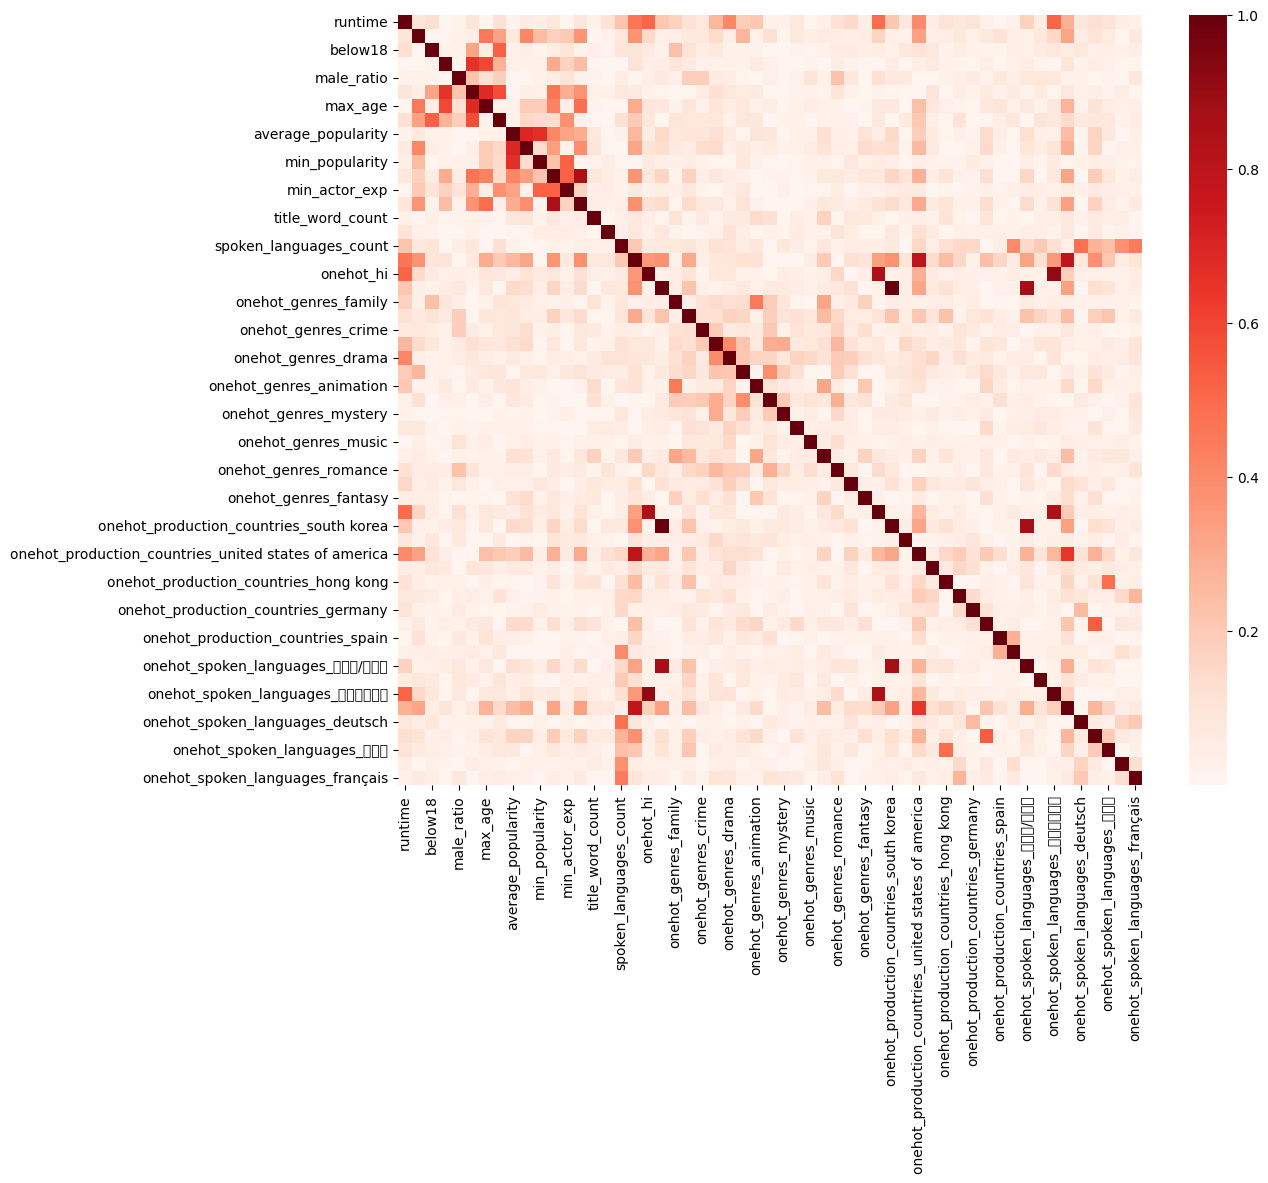

In [273]:
plt.figure(figsize=(12,10))
print(input_low.shape)
corr_matrix = input_low.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

# Drop features 
input_low.drop(to_drop, axis=1, inplace=True)
print(input_low.shape)

sns.heatmap(corr_matrix, annot=False, cmap=plt.cm.Reds)
plt.show()

In [274]:
X_train, X_test, y_train, y_test = train_test_split(input_low, output_low, test_size=0.15, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
print(r2_score(y_test, y_pred))
results.summary()

-0.0684474462732283


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             multiplier   R-squared (uncentered):                   0.797
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              50.02
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                   5.81e-187
Time:                        22:30:32   Log-Likelihood:                         -1302.3
No. Observations:                 687   AIC:                                      2705.
Df Residuals:                     637   BIC:                                      2931.
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
runtime                                                  0.0145      0.004      3.412      0.001       0.006       0.023
number_characters                                       -0.0062      0.025     -0.250      0.802      -0.055       0.042
below18                                                  1.1244      0.722      1.556      0.120      -0.294       2.543
above60                                                 -1.2682      0.629     -2.017      0.044      -2.503      -0.033
male_ratio                                              -0.0993      0.322     -0.308      0.758      -0.733       0.534
average_age                                              0.0492      0.020      2.427      0.015       0.009       0.089
max_age                                                  0.0033      0.010      0.320      0.749      -0.017       0.024
min_age                                                 -0.0225      0.013     -1.771      0.077      -0.048       0.002
average_popularity                                      -0.0119      0.021     -0.559      0.577      -0.054       0.030
max_popularity                                          -0.0048      0.006     -0.857      0.392      -0.016       0.006
min_popularity                                           0.0387      0.021      1.877      0.061      -0.002       0.079
average_actor_exp                                       -0.0661      0.033     -2.026      0.043      -0.130      -0.002
min_actor_exp                                           -0.0235      0.061     -0.383      0.702      -0.144       0.097
title_word_count                                        -0.0100      0.041     -0.242      0.809      -0.091       0.071
release_quarter                                         -0.1245      0.059     -2.125      0.034      -0.240      -0.009
spoken_languages_count                                   0.1514      0.170      0.891      0.373      -0.182       0.485
onehot_en                                                1.2604      0.440      2.863      0.004       0.396       2.125
onehot_hi                                                0.8439      0.574      1.469      0.142      -0.284       1.972
onehot_ko                                                0.9477      0.473      2.005      0.045       0.020       1.876
onehot_genres_family                                    -0.3294      0.292     -1.127      0.260      -0.903       0.245
onehot_genres_action                                    -0.1008      0.207     -0.487      0.626      -0.507       0.305
onehot_genres_crime                                     -0.1105      0.195     -

In [275]:
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(input_high, output_high, test_size=0.3, random_state=42)
model = LinearRegression()#Initializing RFE model
rfe = RFE(model, n_features_to_select=5, step=1)#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  #Fitting the data to model
model.fit(X_rfe,y_train)
# print(rfe.support_)
# print(rfe.ranking_)
X_train_10_best = X_train[X_train.columns[rfe.support_]]
X_test_10_best = X_test[X_test.columns[rfe.support_]]

In [276]:
degree = 2
poly = PolynomialFeatures(degree, interaction_only=True, include_bias=False)
X_train_10_best_poly = poly.fit_transform(X_train_10_best)
X_test_10_best_poly = poly.fit_transform(X_test_10_best)
model = sm.OLS(y_train, X_train_10_best_poly)
results = model.fit()
y_pred = results.predict(X_test_10_best_poly)
print(r2_score(y_test, y_pred))
results.summary()

-0.08452558051715253


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             multiplier   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.059
Date:                Sun, 17 Dec 2023   Prob (F-statistic):             0.0217
Time:                        22:30:34   Log-Likelihood:                -682.28
No. Observations:                 548   AIC:                             1389.
Df Residuals:                     536   BIC:                             1440.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1814      0.235     -0.773      0.440      -0.643       0.280
x2            -0.2241      0.101     -2.222      0.027      -0.422      -0.026
x3             2.1885      0.850      2.576      0.010       0.519       3.858
x4             1.9493      0.425      4.588      0.000       1.115       2.784
x5             2.4099      0.044     54.992      0.000       2.324       2.496
x6             0.1403      1.946      0.072      0.943      -3.682       3.963
x7            -4.3016      4.229     -1.017      0.310     -12.609       4.006
x8            -3.5626      6.123     -0.582      0.561     -15.590       8.465
x9            -0.1814      0.235     -0.773      0.440      -0.643       0.280
x10            0.0789      0.682      0.116      0.908      -1.262       1.420
x11            1.6897      0.905      1.868      0.062      -0.087       3.467
x12           -0.2241      0.101     -2.222      0.027      -0.422      -0.026
const               0          0        nan        nan           0           0
x13           -2.5123      0.888     -2.830      0.005      -4.256      -0.768
x14           -1.5284      0.488     -3.133      0.002      -2.487      -0.570
==============================================================================
Omnibus:                       60.985   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.741
Skew:                           0.344   Prob(JB):                     1.56e-06
Kurtosis:                       2.165   Cond. No.                     1.46e+32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.59e-62. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [277]:
input = input_high
output = output_high

model = LinearRegression()#Initializing RFE model
rfe = RFE(model, n_features_to_select=6, step=1)#Transforming data using RFE
X_rfe = rfe.fit_transform(input,output)  #Fitting the data to model
model.fit(X_rfe,output)
input_10_best = input[input.columns[rfe.support_]]
print(input_10_best.columns)

Index(['male_ratio', 'onehot_en', 'onehot_genres_war',
       'onehot_production_countries_canada',
       'onehot_production_countries_france',
       'onehot_spoken_languages_english'],
      dtype='object')


In [278]:
degree = 1
poly = PolynomialFeatures(degree, interaction_only=True, include_bias=False)
input_10_best_poly = poly.fit_transform(input_10_best)


X_train, X_test, y_train, y_test = train_test_split(input_10_best_poly, output, test_size=0.2, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
print(r2_score(y_test, y_pred))
results.summary()

0.04409597508938745


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             multiplier   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              768.8
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                   1.38e-283
Time:                        22:30:35   Log-Likelihood:                         -798.01
No. Observations:                 627   AIC:                                      1608.
Df Residuals:                     621   BIC:                                      1635.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4797      0.232      2.069      0.039       0.024       0.935
x2            -0.5486      0.360     -1.524      0.128      -1.256       0.158
x3            -0.3253      0.178     -1.826      0.068      -0.675       0.024
x4            -0.3091      0.151     -2.042      0.042      -0.606      -0.012
x5            -0.3461      0.186     -1.861      0.063      -0.711       0.019
x6             2.6111      0.397      6.574      0.000       1.831       3.391
==============================================================================
Omnibus:                       51.804   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.337
Skew:                           0.395   Prob(JB):                     2.59e-07
Kurtosis:                       2.267   Cond. No.                         23.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Check par year range

In [ ]:
for years in df['year_group'].unique():
    input_df = df[df['year_group'] == years].drop(['multiplier','budget', 'revenue', 'movie_id', 'release_date', 'title', 'year', 'year_group', 'genres', 'original_language', 'production_countries', 'spoken_languages'], axis=1)
    output_df = df[df['year_group'] == years]['multiplier']
    input_l = input_df[input_df['category'] == 'low'].drop(['category'], axis=1)
    input_h = input_df[input_df['category'] == 'high'].drop(['category'], axis=1)
    output_l = output_df[input_df['category'] == 'low']
    output_h = output_df[input_df['category'] == 'high']
    
    input_low, output_low = remove_outliers(input_l, output_l)
    input_high, output_high = remove_outliers(input_h, output_h)

    for col in input_high.columns:
        if (input_high[col].sum() < 30) and ('onehot' in col):
            input_high.drop(col, axis=1, inplace=True)

    for col in input_low.columns:
        if (input_low[col].sum() < 10) and ('onehot' in col):
            input_low.drop(col, axis=1, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(input_low, output_low, test_size=0.15, random_state=42)
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    y_pred = results.predict(X_test)
    # print(r2_score(y_test, y_pred))
    # print(results.summary())

### Classification

In [177]:
input_df = df.drop(['multiplier','budget', 'revenue', 'movie_id', 'release_date', 'title', 'year', 'year_group', 'genres', 'original_language', 'production_countries', 'spoken_languages'], axis=1)
output_df = df['multiplier']

In [194]:
input_l = input_df[input_df['category'] == 'low'].drop(['category'], axis=1)
input_h = input_df[input_df['category'] == 'high'].drop(['category'], axis=1)
output_l = output_df[input_df['category'] == 'low']
output_h = output_df[input_df['category'] == 'high']

input_low, output_low = remove_outliers(input_l, output_l, low=0.1, high=0)
input_high, output_high = remove_outliers(input_h, output_h, low=0, high=0.9)

output_low = pd.qcut(output_low, 3, labels=['low', 'medium', 'high'])
output_high = pd.qcut(output_high, 3, labels=['low', 'medium', 'high'])

for col in input_high.columns:
    if (input_high[col].sum() < 50) and ('onehot' in col):
        input_high.drop(col, axis=1, inplace=True)

for col in input_low.columns:
    if (input_low[col].sum() < 30) and ('onehot' in col):
        input_low.drop(col, axis=1, inplace=True)

C:\Users\jojod\AppData\Local\Temp\ipykernel_30928\1211680359.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input = input[output > threshold_low]
C:\Users\jojod\AppData\Local\Temp\ipykernel_30928\1211680359.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input = input[output > threshold_low]


In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error


X = input_low  # Two features for simplicity
y = output_low # Binary classification based on a simple condition

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# # Calculate R-squared score
# r2 = r2_score(y_test, y_pred)
# print(f"R-squared Score: {r2:.2f}")

# # Optionally, display other metrics like Mean Squared Error (MSE)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.2f}")


Accuracy: 0.36

Classification Report:
              precision    recall  f1-score   support

        high       0.43      0.30      0.35        30
         low       0.40      0.36      0.38        28
      medium       0.29      0.43      0.34        23

    accuracy                           0.36        81
   macro avg       0.37      0.36      0.36        81
weighted avg       0.38      0.36      0.36        81



### Optimisation

In [53]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score

# df_cat = df[df['category'] == 'high'].drop(['category'], axis=1)
# X = df_cat.drop(['multiplier','budget', 'revenue', 'movie_id', 'release_date', 'title', 'year', 'genres', 'original_language', 'production_countries', 'spoken_languages'], axis=1)
# y= df_cat['multiplier']
X = input_high
y = output_high

# Create a linear regression model
model = RandomForestRegressor()

# Perform cross-validation (e.g., 5-fold cross-validation) with R-squared as the scoring metric
r2_scorer = make_scorer(r2_score)
cv_scores_r2 = cross_val_score(model, X, y, cv=10, scoring=r2_scorer)

# Display cross-validation R-squared scores
print("Cross-Validation R-squared Scores:")
print(cv_scores_r2)

# Calculate and display mean R-squared
mean_r2 = np.mean(cv_scores_r2)
print(f"\nMean R-squared: {mean_r2}")


Cross-Validation R-squared Scores:
[ 0.04523042 -0.03329454 -0.06293004 -0.09309164  0.16315727 -0.16333553
 -0.04193707 -0.10660683 -0.17604057 -0.14481863]

Mean R-squared: -0.06136671601828031


In [102]:
print(X['year_group'].unique())

[2020 2015 2010 2005 2000 1995 1990 1985 1980]


In [166]:
X_2000 = X[X['year_group'] == 2010][['number_characters','average_age', 'max_age', 'min_actor_exp', 'onehot_genres_horror']]
y_2000 = y[X['year_group'] == 2010]

X_train, X_test, y_train, y_test = train_test_split(X_2000, y_2000, test_size=0.2, random_state=42)
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
print(r2_score(y_test, y_pred))
results.summary()

-0.22827405493025688


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             multiplier   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              92.30
Date:                Sun, 17 Dec 2023   Prob (F-statistic):                    2.01e-38
Time:                        19:40:50   Log-Likelihood:                         -226.69
No. Observations:                 119   AIC:                                      463.4
Df Residuals:                     114   BIC:                                      477.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
number_characters        0.1377      0.026      5.271      0.000       0.086       0.189
average_age             -0.0533      0.029     -1.806      0.074      -0.112       0.005
max_age                  0.0463      0.019      2.410      0.018       0.008       0.084
min_actor_exp            0.2710      0.195      1.394      0.166      -0.114       0.656
onehot_genres_horror     0.6069      0.984      0.617      0.539      -1.342       2.556
==============================================================================
Omnibus:                       15.055   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.075
Skew:                           0.788   Prob(JB):                     0.000196
Kurtosis:                       3.980   Cond. No.                         532.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## using Decisions Tree regressor

In [57]:
X_train, X_test, y_train, y_test = train_test_split(input_high, output_high, test_size=0.3, random_state=42)

In [55]:
X_train = standardize_input(X_train)
X_test = standardize_input(X_test)

In [58]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train,y_train)
y_pred = decision_tree_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: -0.8534383567214374


In [107]:
#replace true and false with 1 and 0
X_train = X_train.replace(True, 1)
X_train = X_train.replace(False, 0)
display(X_train.head())

,number_characters,onehot_genres_animation,onehot_genres_crime,onehot_genres_adventure,onehot_genres_science fiction,onehot_genres_history,onehot_genres_war
0,0.665930,-0.41677,-0.384783,-0.993677,-0.570026,-0.241175,-0.215546
1,0.082625,-0.41677,-0.384783,-0.993677,-0.570026,4.146361,-0.215546
2,-1.278420,-0.41677,-0.384783,1.006363,1.754305,-0.241175,-0.215546
3,-0.306245,-0.41677,-0.384783,1.006363,1.754305,-0.241175,-0.215546
4,1.249234,-0.41677,-0.384783,-0.993677,-0.570026,-0.241175,-0.215546


In [108]:
bounds = []
for column in X_train.columns:
    bounds.append((X_train[column].min(), X_train[column].max()))
bounds

[(-2.0561601637785656, 4.3601940938023285),
 (-0.4167700450745759, 2.3994046880722006),
 (-0.38478338377220045, 2.598864821543387),
 (-0.9936774919374967, 1.006362736515422),
 (-0.5700262906119291, 1.7543050495556785),
 (-0.24117534720288886, 4.146360776911205),
 (-0.21554622935962128, 4.639375984311848)]

In [109]:
from itertools import product

def objective_function(features):
    features = np.array(features).reshape(1, -1)
    df_features = pd.DataFrame(features, columns=X_train.columns)
    prediction = decision_tree_model.predict(df_features).flatten()[0]
    print(f"{features} -> {prediction}")
    return prediction

# Define the ranges for each feature
# feature_ranges = [range(X_train[column].min(),X_train[column].max(),1) for column in X_train.columns]

# Generate all combinations of features
feature_combinations = list(product(*bounds))

# Evaluate the objective function for each combination
best_score = float('-inf')
best_features = None

for features in feature_combinations:
    score = objective_function(features)
    
    if score > best_score:
        best_score = score
        best_features = features

print("Best Features:", best_features)
print("Best Score:", best_score)


[[-2.05616016 -0.41677005 -0.38478338 -0.99367749 -0.57002629 -0.24117535
  -0.21554623]] -> 0.9607047680555556
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749 -0.57002629 -0.24117535
   4.63937598]] -> 0.9607047680555556
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749 -0.57002629  4.14636078
  -0.21554623]] -> 3.131016355
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749 -0.57002629  4.14636078
   4.63937598]] -> 3.131016355
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749  1.75430505 -0.24117535
  -0.21554623]] -> 0.9607047680555556
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749  1.75430505 -0.24117535
   4.63937598]] -> 0.9607047680555556
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749  1.75430505  4.14636078
  -0.21554623]] -> 3.131016355
[[-2.05616016 -0.41677005 -0.38478338 -0.99367749  1.75430505  4.14636078
   4.63937598]] -> 3.131016355
[[-2.05616016 -0.41677005 -0.38478338  1.00636274 -0.57002629 -0.24117535
  -0.21554623]] -> 0.9607047680555556
[[-2.05616016 -0.416

## Optimisation of linear Regression

In [335]:
input = input_high
output = output_high
model = sm.OLS(output, input)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             multiplier   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.889
Method:                 Least Squares   F-statistic:                              131.5
Date:                Mon, 18 Dec 2023   Prob (F-statistic):                        0.00
Time:                        00:09:13   Log-Likelihood:                         -951.55
No. Observations:                 784   AIC:                                      1999.
Df Residuals:                     736   BIC:                                      2223.
Df Model:                          48                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
runtime                                                  0.0036      0.002      1.795      0.073      -0.000       0.008
number_characters                                        0.0235      0.008      2.851      0.004       0.007       0.040
below18                                                  0.4565      0.538      0.848      0.397      -0.600       1.513
above60                                                 -1.0332      0.417     -2.475      0.014      -1.853      -0.214
male_ratio                                               0.1682      0.234      0.719      0.472      -0.291       0.627
average_age                                              0.0120      0.010      1.180      0.239      -0.008       0.032
max_age                                                  0.0032      0.005      0.695      0.487      -0.006       0.012
min_age                                                  0.0037      0.006      0.621      0.535      -0.008       0.015
average_popularity                                       0.0043      0.009      0.466      0.641      -0.014       0.023
max_popularity                                          -0.0010      0.002     -0.576      0.565      -0.004       0.002
min_popularity                                          -0.0084      0.019     -0.434      0.664      -0.046       0.030
average_actor_exp                                       -0.0110      0.022     -0.503      0.615      -0.054       0.032
min_actor_exp                                            0.0828      0.044      1.874      0.061      -0.004       0.169
max_actor_exp                                            0.0078      0.006      1.382      0.167      -0.003       0.019
title_word_count                                         0.0242      0.018      1.324      0.186      -0.012       0.060
release_quarter                                          0.0017      0.029      0.057      0.954      -0.056       0.059
spoken_languages_count                                   0.1146      0.065      1.775      0.076      -0.012       0.241
onehot_en                                               -0.3814      0.463     -0.823      0.411      -1.291       0.528
onehot_genres_family                                    -0.0808      0.126     -0.643      0.520      -0.327       0.166
onehot_genres_war                                       -0.3088      0.176     -1.756      0.079      -0.654       0.036
onehot_genres_action                                     0.0691      0.082      0.838      0.402      -0.093       0.231
onehot_genres_crime                                     -0.2282      0.098     -

In [336]:
# these are the parameters for the model prediction
results.params

runtime                                                 0.003612
number_characters                                       0.023544
below18                                                 0.456511
above60                                                -1.033237
male_ratio                                              0.168158
average_age                                             0.012015
max_age                                                 0.003161
min_age                                                 0.003657
average_popularity                                      0.004340
max_popularity                                         -0.001019
min_popularity                                         -0.008402
average_actor_exp                                      -0.010991
min_actor_exp                                           0.082783
max_actor_exp                                           0.007752
title_word_count                                        0.024225
release_quarter          

#### Set bounds

In [337]:
bounds = []
for column in input.columns:
    bounds.append((input[column].min(), input[column].max()))
bounds

[(77.0, 191.0),
 (2.0, 47.0),
 (0.0, 0.6666666666666666),
 (0.0, 0.6666666666666666),
 (0.25, 1.0),
 (22.6, 65.4),
 (31.0, 95.0),
 (2.0, 48.0),
 (12.826666666666666, 86.07249999999999),
 (13.221, 200.246),
 (9.975, 33.781),
 (0.1, 17.166666666666668),
 (0.0, 8.0),
 (1.0, 62.0),
 (1, 11),
 (1, 4),
 (1, 11),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]

#### Set integer constraints

In [338]:
def get_integer_constraint(features):
   sum = 0
   for feature in features:
      sum += np.abs(np.floor(feature) - feature)
   return sum

integer_constraint = {'type': 'eq', 'fun': get_integer_constraint}

### Define Initial Guess

In [342]:
def find_init_guess(input, output, name_output_column = 'multiplier'):
    '''
    Find the initial guess for the optimization algorithm
    :param dataframe: dataframe with the data
    :param name_output_column: name of the output column to maximize
    :return: initial guess of the features to maximize the output, the max value of the output and the index of the max value
    '''
    dataframe = pd.concat([input, output], axis=1)
    max = dataframe[name_output_column].max()
    idx_max = dataframe[name_output_column].idxmax()
    features = dataframe.loc[idx_max].drop(name_output_column).values
    return features, max, idx_max

In [343]:
init_features, initial_max, _ = find_init_guess(input, output)
# initial_features = np.zeros(len(input.columns)).reshape(1, -1)
# df_init = pd.DataFrame(initial_features, columns=input.columns)
# init_f = df_init.values
# init_f[0]

### Perform Optimization

In [344]:
from scipy import optimize

# Your trained model
def model_prediction(features):
    prediction = (features * results.params).sum()
    return prediction

# Objective function for optimization
def objective_function(features):
    return -model_prediction(features)  #Minimize the negative of the output

# Optimize feature values
result = optimize.minimize(objective_function, init_features, method='SLSQP', bounds=bounds, constraints=[integer_constraint] , options={'eps': 0.1})

# Optimized feature values
optimized_features = result.x

# Evaluate the model with optimized features
optimized_output = model_prediction(optimized_features)

c:\Users\jojod\anaconda3\envs\ADA\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [345]:
result

 message: Iteration limit reached
 success: False
  status: 9
     fun: -6.759254132315255
       x: [ 1.422e+02  3.868e+01 ...  1.000e+00  4.426e-14]
     nit: 100
     jac: [-3.612e-03 -2.354e-02 ... -2.248e-02  1.190e-02]
    nfev: 5225
    njev: 99

In [347]:
print("Optimized features: {}".format(np.around(optimized_features, decimals=3)))
print("Optimized output: {}".format(np.around(optimized_output, decimals=3)))
print("Initial features: {}".format(init_features, decimals=3))
print("Initial output: {}".format(initial_max, decimals=3))

Optimized features: [1.42181e+02 3.86770e+01 6.67000e-01 0.00000e+00 1.00000e+00 3.87660e+01
 7.60550e+01 6.09500e+00 1.29200e+01 4.19530e+01 1.03530e+01 1.00000e-01
 8.00000e+00 3.21390e+01 1.10000e+01 3.70400e+00 1.10000e+01 0.00000e+00
 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00
 2.46000e-01 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 3.81000e-01 1.00000e+00
 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]
Optimized output: 6.759
Initial features: [1.69000000e+02 1.90000000e+01 5.26315789e-02 2.63157895e-01
 6.84210526e-01 4.55789474e+01 8.20000000e+01 1.40000000e+01
 3.15152105e+01 1.04258000e+02 1.12110000e+01 7.94736842e+00
 0.00000000e+00 3.10000000e+01 1.00000000e+00 4.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.